In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(torch.cuda.get_arch_list())

print(f"Is CUDA supported by this system?{torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")
       
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
import torch
torch.cuda.empty_cache()

## Software Implementation of ECGNet

In [1]:
import onnx
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
from PIL import Image
from torch import optim
from tqdm import tqdm
import netron
import time
from IPython.display import IFrame


class CustomDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = []
        self.labels = []
        for label in os.listdir(root_dir):
            label_dir = os.path.join(root_dir, label)
            for file in os.listdir(label_dir):
                file_path = os.path.join(label_dir, file)
                self.samples.append(file_path)
                self.labels.append(int(label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = np.load(self.samples[idx])
        sample = np.squeeze(sample)  
        sample = np.expand_dims(sample, axis=0)  
        sample = np.expand_dims(sample, axis=0) 
        sample = torch.from_numpy(sample).float()
        label = self.labels[idx]
        return sample, label

# Load training data
train_data = CustomDataset(root_dir='datasets/ecgdata/train_data')
# Load testing data
test_data = CustomDataset(root_dir='datasets/ecgdata/test_data')

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

def show_netron(model_path, port):
    time.sleep(3.)
    netron.start(model_path, address=("localhost", port), browse=False)
    return IFrame(src=f"http://localhost:{port}/", width="100%", height=400)


## Define Quantized Model in Brevitas 

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import brevitas.nn as qnn
import numpy as np

class ECGNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        myWeight_bit_width = 4
        self.features = nn.Sequential(
            qnn.QuantIdentity(),

            qnn.QuantConv2d(1, 16, kernel_size=(1, 5),
                            weight_bit_width=myWeight_bit_width),
            qnn.QuantReLU(inplace=True, weight_bit_width=myWeight_bit_width),
            qnn.QuantConv2d(16, 32, kernel_size=(1, 5),
                            weight_bit_width=myWeight_bit_width),
            qnn.QuantReLU(inplace=True, weight_bit_width=myWeight_bit_width),
            nn.MaxPool2d(kernel_size=(1, 4), stride=(1, 4)),

            qnn.QuantConv2d(32, 16, kernel_size=(1, 3),
                            weight_bit_width=myWeight_bit_width),
            qnn.QuantReLU(inplace=True, weight_bit_width=myWeight_bit_width),
            qnn.QuantConv2d(16, 16, kernel_size=(1, 3),
                            weight_bit_width=myWeight_bit_width),
            qnn.QuantReLU(inplace=True, weight_bit_width=myWeight_bit_width),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
        )

        self.classifier = nn.Sequential(
            qnn.QuantLinear(16 * 13, num_classes, bias=True,
                            weight_bit_width=myWeight_bit_width),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x

## Train Loop

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(876)
np.random.seed(0)

model = ECGNet()

model.to(device)


In [ ]:
# Number of epochs
num_epochs = 20
# Loss criterion and optimizer

criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    criterion = criterion.cuda()

optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
lr_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)


train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} Training', leave=True)
    for images, labels in train_progress_bar:
        images, labels = images.to(device), labels.to(device)
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        # Backward pass + run optimizer to update weights
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Keep track of loss value
        train_running_loss += loss.item()

        pred = torch.argmax(outputs, dim=1)
        total_train += labels.size(0)
        correct_train += (pred == labels).sum().item()

        train_progress_bar.set_postfix(loss=f'{train_running_loss/(len(train_progress_bar)):.4f}')

    train_loss_avg = train_running_loss / len(train_loader)
    train_losses.append(train_loss_avg)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss_avg:.4f}')

    # Testing phase
    model.eval()
    test_running_loss = 0.0
    correct_test = 0
    total_test = 0

    test_progress_bar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} Validation', leave=True)

    with torch.no_grad():
        for images, labels in test_progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_running_loss += loss.item()

            predicted = torch.argmax(outputs, dim=1)

            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            test_progress_bar.set_postfix(val_loss=f'{test_running_loss/(len(test_progress_bar)):.4f}')

    test_loss_avg = test_running_loss / len(test_loader)
    test_losses.append(test_loss_avg)
    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)
    lr_scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {test_loss_avg:.4f}, Validation Accuracy: {test_accuracy:.4f}')

print("Training Finished!")


## Plot train and test curves

In [ ]:
import matplotlib.pyplot as plt

# training and test loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# model_path = "trained_models/ecgnet_w4a4_model.pth"
# torch.save(model.state_dict(), model_path)

## Classify single image and measure time taken

In [3]:
#Device is CPU only for single image classification
import torch
device = torch.device("cpu")
print(device)
model_path = "trained_models/ecgnet_w4a4_model.pth"
model = ECGNet()
model.to(device)
model.load_state_dict(torch.load(model_path),strict = False)


cpu


<All keys matched successfully>

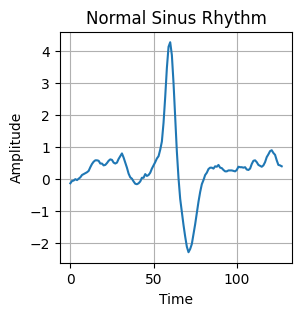

In [4]:
input_data = np.load("datasets/val_data/1/118_104895.npy")
input_data_1d = np.flip(input_data.squeeze(),axis=0)

# Plot the data
plt.figure(figsize=(3, 3))
plt.plot(input_data_1d)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Normal Sinus Rhythm')
plt.grid(True)
plt.show()

In [5]:
import time

model.eval() 

input_tensor = torch.from_numpy(input_data).float().unsqueeze(0)

start_time = time.time()
with torch.no_grad():
    output = model(input_tensor)
inference_time = time.time() - start_time

if np.argmax(output[0]) == 1:
    print("Returned Normal Sinus Rhythm")
else:
    print("Wrong Prediction!!")

print("Inference time taken for single image on CPU: {:.4f} seconds".format(inference_time))

Returned Normal Sinus Rhythm
Inference time taken for single image on CPU: 0.0410 seconds


C:\Users\asrin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_tensor.py:1394: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ..\c10/core/TensorImpl.h:1911.)
  return super().rename(names)


## Validation Accuracy on CPU

Validation Accuracy Score: 0.9407744874715261
F1 Score: 0.9433688870707131


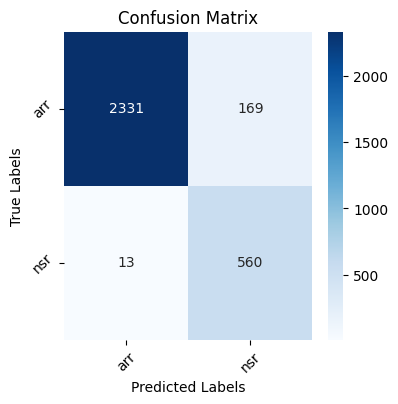

CPU times: total: 20.7 s
Wall time: 7.4 s


In [6]:
%%time
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets


def validate(model, validation_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

validation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

class CustomDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = []
        self.labels = []
        for label in os.listdir(root_dir):
            label_dir = os.path.join(root_dir, label)
            for file in os.listdir(label_dir):
                file_path = os.path.join(label_dir, file)
                self.samples.append(file_path)
                self.labels.append(int(label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = np.load(self.samples[idx])
        # Assume the shape of sample is (1, 1, 128)
        sample = np.squeeze(sample)  # Remove single-dimensional entries
        sample = np.expand_dims(sample, axis=0)  # Add a dimension for the channel
        sample = np.expand_dims(sample, axis=0)  # Add a dimension for the height (1)
        sample = torch.from_numpy(sample).float()
        label = self.labels[idx]
        return sample, label


validation_data = CustomDataset(root_dir="datasets/last_val_data/")

validation_dataloader = DataLoader(validation_data, batch_size=32, shuffle=True)


y_true, y_pred = validate(model, validation_dataloader)


accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Validation Accuracy Score: {accuracy}')
print(f'F1 Score: {f1}')

class_names = ['arr','nsr']


cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names, rotation=45)
ax.yaxis.set_ticklabels(class_names, rotation=45)
plt.show()


## Total Time taken only to calculate validation accuracy on CPU

In [ ]:
%%time
#Only time taken on CPU
y_true, y_pred = validate(model, validation_dataloader)

# Calculate accuracy score and f1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

# Print accuracy score and f1 score
print(f'Validation Accuracy Score: {accuracy}')
print(f'F1 Score: {f1}')

## Throughput and Latency Measurements

In [9]:
import torch
import time


input_size = (1,1,1,128)
num_iterations = 100

def benchmark_cpu(model, input_size):
    model.eval()
    input_data = torch.randn(input_size)
    total_time = 0.0
    for _ in range(num_iterations):
        start_time = time.time()
        with torch.no_grad():
            _ = model(input_data)
        end_time = time.time()
        total_time += end_time - start_time
    latency = total_time / num_iterations
    throughput = num_iterations / total_time
    return latency, throughput


# Example usage
cpu_latency, cpu_throughput = benchmark_cpu(model, input_size)

# Print results
print("CPU Latency:", cpu_latency, "seconds")
print("CPU Throughput:", cpu_throughput, "inferences per second")



CPU Latency: 0.01988598585128784 seconds
CPU Throughput: 50.2866695912508 inferences per second
